# Failure Prediction & Failure Type Classification

## Imports and settings

In [16]:
import os
import sys
import math
import numpy as np
import pandas as pd
from pathlib import Path


# Machine learning imports
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
precision_recall_curve,
average_precision_score,
precision_score,
recall_score,
confusion_matrix,
classification_report,
f1_score,
)


import matplotlib.pyplot as plt


# Optional XGBoost: try import, otherwise we'll skip it
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except Exception:
    XGBOOST_AVAILABLE = False

## Load dataset & EDA

In [17]:
# Load the dataset
df = pd.read_csv(r"C:\Users\bbuser\Desktop\Jupyter\ai4i2020.csv")
df.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

In [5]:
df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [6]:
df.isna().sum()

UDI                        0
Product ID                 0
Type                       0
Air temperature [K]        0
Process temperature [K]    0
Rotational speed [rpm]     0
Torque [Nm]                0
Tool wear [min]            0
Machine failure            0
TWF                        0
HDF                        0
PWF                        0
OSF                        0
RNF                        0
dtype: int64

In [7]:
# Confirm failure column is binary
df['Machine failure'].value_counts()

Machine failure
0    9661
1     339
Name: count, dtype: int64

In [19]:
# Binary target: 'Machine failure'
y_binary = df['Machine failure']

## Feature Engineering

In [20]:
# Features (numeric sensor columns)
feature_cols = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X = df[feature_cols]

In [24]:
# Multi-class target: build from the 5 failure type flags
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']
def map_failure_type(row):
    for f in failure_types:
        if row[f] == 1:
            return f
    return 'NoFailure'


df['failure_type'] = df.apply(map_failure_type, axis=1)
y_multi_raw = df['failure_type']

In [25]:
# Encode multiclass labels
le_multi = LabelEncoder()
y_multi = le_multi.fit_transform(y_multi_raw)


print("\nFailure type classes:", list(le_multi.classes_))


Failure type classes: ['HDF', 'NoFailure', 'OSF', 'PWF', 'RNF', 'TWF']


In [26]:
# Train/test split
X_train, X_test, yb_train, yb_test, ym_train, ym_test = train_test_split(
X, y_binary, y_multi, test_size=0.25, random_state=42, stratify=y_binary
)

In [27]:
# Preprocessing pipeline
preproc = Pipeline([
('imputer', SimpleImputer(strategy='median')),
('scaler', StandardScaler()),
])


X_train_prep = preproc.fit_transform(X_train)
X_test_prep = preproc.transform(X_test)

## Model 1: Binary failure prediction

In [29]:
models_binary = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'LogisticRegression': LogisticRegression(max_iter=1000, solver='lbfgs')
}


fitted_binary = {}
for name, model in models_binary.items():
    print(f"Training binary model: {name}")
    model.fit(X_train_prep, yb_train)
    fitted_binary[name] = model

Training binary model: RandomForest
Training binary model: GradientBoosting
Training binary model: LogisticRegression


### Evaluate binary models with Precision-Recall

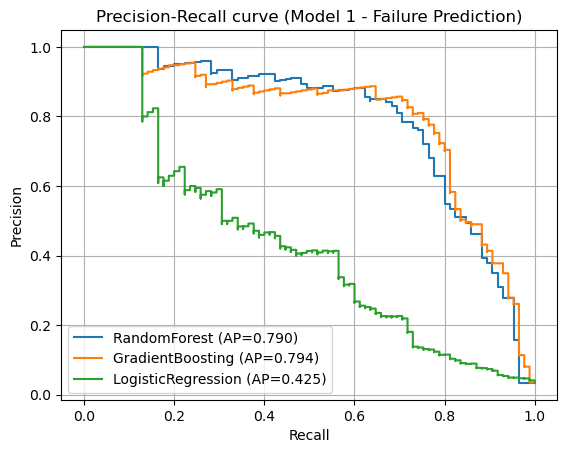


Binary model summary:
RandomForest: Precision=0.857, Recall=0.635
GradientBoosting: Precision=0.887, Recall=0.647
LogisticRegression: Precision=0.737, Recall=0.165


In [30]:
plt.figure()
for name, m in fitted_binary.items():
    y_scores = m.predict_proba(X_test_prep)[:, 1] if hasattr(m, 'predict_proba') else m.decision_function(X_test_prep)
    precision, recall, _ = precision_recall_curve(yb_test, y_scores)
    ap = average_precision_score(yb_test, y_scores)
    plt.step(recall, precision, where='post', label=f"{name} (AP={ap:.3f})")


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve (Model 1 - Failure Prediction)')
plt.legend()
plt.grid(True)
plt.show()


print("\nBinary model summary:")
for name, m in fitted_binary.items():
    y_pred = m.predict(X_test_prep)
    p = precision_score(yb_test, y_pred, zero_division=0)
    r = recall_score(yb_test, y_pred, zero_division=0)
    print(f"{name}: Precision={p:.3f}, Recall={r:.3f}")

## Model 2: Multi-class failure type classification

In [31]:
models_multi = {
    'DecisionTree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'GaussianNB': GaussianNB(),
}

if XGBOOST_AVAILABLE:
    models_multi['XGBoost'] = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)


fitted_multi = {}
for name, model in models_multi.items():
    print(f"Training multi-class model: {name}")
    model.fit(X_train_prep, ym_train)
    fitted_multi[name] = model

Training multi-class model: DecisionTree
Training multi-class model: SVM
Training multi-class model: GaussianNB
Training multi-class model: XGBoost


C:\Users\bbuser\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [09:50:52] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Evaluate multi-class models


=== Evaluation for DecisionTree ===
              precision    recall  f1-score   support

         HDF       0.89      0.86      0.87        36
   NoFailure       0.99      0.99      0.99      2411
         OSF       0.25      0.17      0.20        18
         PWF       0.70      0.88      0.78        16
         RNF       0.00      0.00      0.00         6
         TWF       0.06      0.08      0.07        13

    accuracy                           0.97      2500
   macro avg       0.48      0.49      0.48      2500
weighted avg       0.97      0.97      0.97      2500



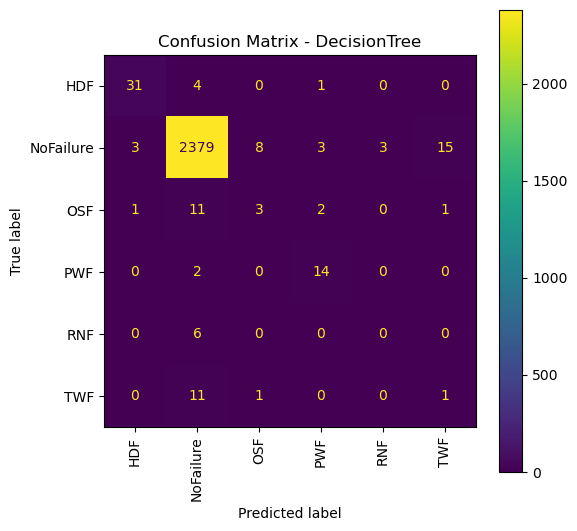


=== Evaluation for SVM ===
              precision    recall  f1-score   support

         HDF       1.00      0.06      0.11        36
   NoFailure       0.97      1.00      0.99      2411
         OSF       0.67      0.22      0.33        18
         PWF       0.90      0.56      0.69        16
         RNF       0.00      0.00      0.00         6
         TWF       0.00      0.00      0.00        13

    accuracy                           0.97      2500
   macro avg       0.59      0.31      0.35      2500
weighted avg       0.96      0.97      0.96      2500



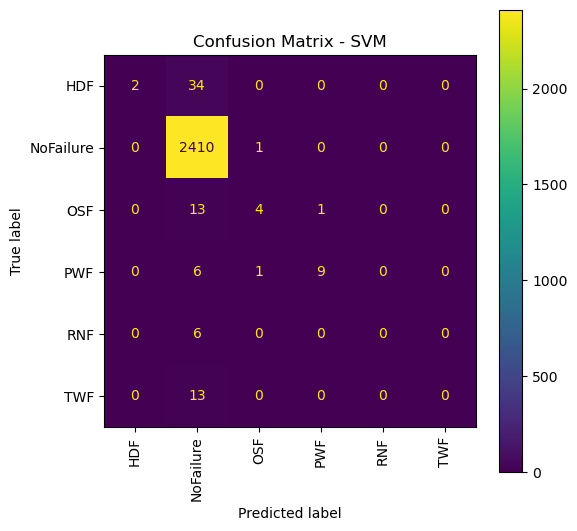


=== Evaluation for GaussianNB ===
              precision    recall  f1-score   support

         HDF       0.42      0.67      0.52        36
   NoFailure       0.98      0.97      0.98      2411
         OSF       0.43      0.83      0.57        18
         PWF       0.22      0.44      0.29        16
         RNF       0.00      0.00      0.00         6
         TWF       0.00      0.00      0.00        13

    accuracy                           0.95      2500
   macro avg       0.34      0.48      0.39      2500
weighted avg       0.96      0.95      0.96      2500



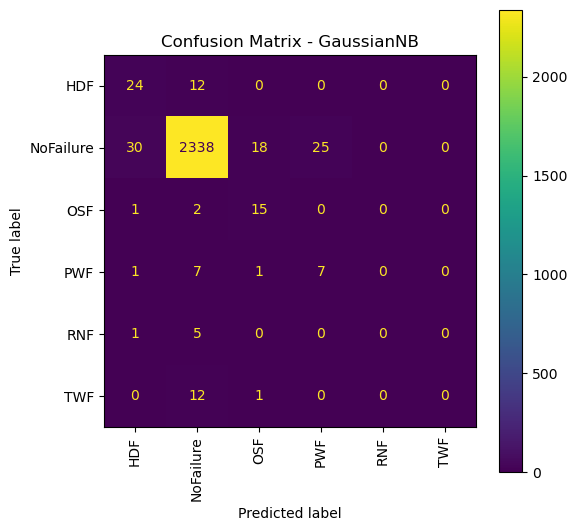


=== Evaluation for XGBoost ===
              precision    recall  f1-score   support

         HDF       0.92      0.92      0.92        36
   NoFailure       0.99      1.00      0.99      2411
         OSF       0.85      0.61      0.71        18
         PWF       0.68      0.94      0.79        16
         RNF       0.00      0.00      0.00         6
         TWF       0.00      0.00      0.00        13

    accuracy                           0.98      2500
   macro avg       0.57      0.58      0.57      2500
weighted avg       0.98      0.98      0.98      2500



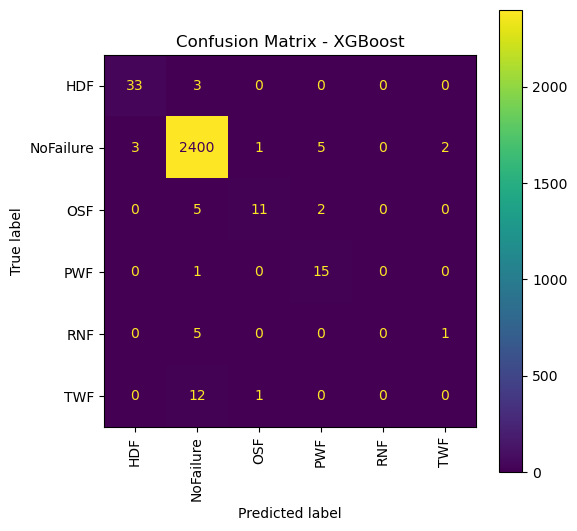

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay


for name, m in fitted_multi.items():
    print(f"\n=== Evaluation for {name} ===")
    ym_pred = m.predict(X_test_prep)
    print(classification_report(ym_test, ym_pred, target_names=le_multi.classes_, zero_division=0))
    cm = confusion_matrix(ym_test, ym_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_multi.classes_)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, xticks_rotation='vertical')
    ax.set_title(f'Confusion Matrix - {name}')
    plt.show()

In [33]:
print("\nDone. Models trained on ai4i2020 dataset.")


Done. Models trained on ai4i2020 dataset.
